# __3장 평가__
---


## __03_01 정확도__ 
---
- __정확도__ = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
    * 정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표이지만, 이진 분류에서는 데이터의 구성에 따라 ML모델의 성능을 왜곡할 수 있기 때문에 정확도 하나만으로 성능을 판단하지는 않는다. 

In [3]:
# 사이킷런의 BaseEstimator 를 상속받아 Customized 형태의 Estimator 생성
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 Sex 피처가 1이면 0, 아니면 1이라고 예측
    def predict(self, X):
        pred=np.zeros((X.shape[0],1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i]=0
            else:
                pred[i]=1
        return pred

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 타이타닉 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv("titanic_train.csv")
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 앞서 생성한 MyDummyClassifier를 이용해 타이타닉의 생존자 수 예측
myclf=MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions=myclf.predict(X_test)
print('Dummy Classifier의 정확도: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))


Dummy Classifier의 정확도: 0.7877


### MNIST 데이터 세트
- 사이킷런의 load_digits( )를 통해 MNIST 데이터 세트를 제공한다.
- 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 숫자 Digit을 예측하는 데 사용된다.
- 0부터 9사이의 값 중 7만 T, 나머지는 F로 변환해 이진 분류 문제로 바꾼다. (전체의 10% 만 T)

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as dp

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력 값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
    # 사이키런의 내장 데이터 세트 load_digits()를 통해 MNIST 데이터 로드
digits=load_digits()

# digit 번호가 7이면 T & astype(int)로 변환해 7이면 1, 나머지는 0으로 바꾼다.
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test=train_test_split(digits.data, y, random_state=11)

# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도: {0:.3f}'.format(accuracy_score(y_test, fakepred))) 

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도: 0.900


- 위의 예제처럼 모든 것을 0으로만 예측해도 90%가 정확도로 나오는 불균형한 레이블 데이터 세트는 성능 수치로 사용해서는 안 된다. 이러한 문제점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다. 

## __03_02 오차행렬__
---
- 이진 분류
- 학습된 분류 모델이 예측을 수행하며 얼마나 헷갈리고 있는 지 알려줌!
- 예측 오류가 얼마인지 + 어떠한 유형의 예측 오류인지 알려주는 지표

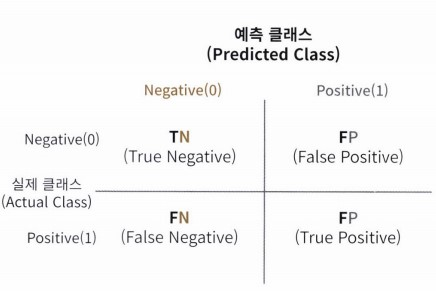

- TN 예측값을 Negative 값 0으로 예측했고, 실제 값과 같음
- FP 예측값을 Positive 값 1로 예측, 실제 값은 0
- FN 예측값을 Negative 값 0으로 예측, 실제 값은 1
- TN 예측값을 Positive 값 1로 예측, 실제 값과 같음

In [31]:
# 사이킷런은 오차행렬을 구하기 위해 confusion_matrix()를 제공한다. 
# 앞서 다룬 MyFakeClassifier의 예측 성능 지표를 오차행렬로 사용
# MyFakeClassifier의 예측 결과인 fakepred와 실제 결과인 y_test를 인자로 입력해 오차 행렬을 배열 형태로 출력

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred) 

array([[405,   0],
       [ 45,   0]], dtype=int64)

- ndarray 형태로 출력된 오차 행렬
- 이진 분류의 예측 클래스 표와 동일한 위치를 가지고 array에서 가져올 수 있다.
- TN: [0,0]=405, FP: [0,1]=0, FN: [1,0]=45, FP: [1,1]=0

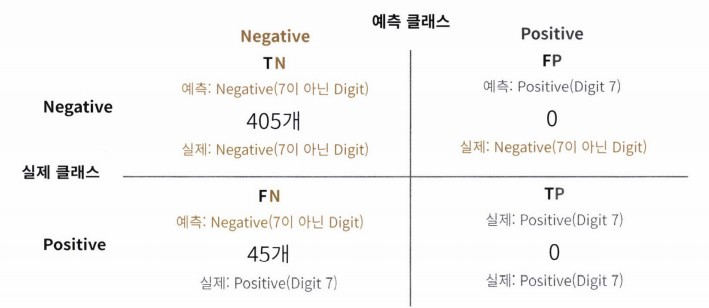

- TP, TN, FP, TN 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보를 제공한다.
- Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있음
- 정확도는 예측값과 실제 값이 얼마나 동일한가에 대한 비율만으로 결정된다. 즉, 오차행렬의 TN과 TP에 좌우된다. 
* 정확도=(TN+TP)/(TN+FP+FN+TP)
* 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우는 Negative로 0 값을 부여하는 경우가 많다. 
* 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML알고리즘은 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 있다. 



## __03_03 정밀도와 재현율__
---
* 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가지표
* 정밀도와 재현율 모두 동일하게 TP를 높이지만 정밀도는 FP, 재현율은 FN을 낮추는 데 집중한다. 
* __정밀도__=TP/(FP+TP)
    * 정밀도: 예측을 Positive로 한 대상 중에 실제 값이 Positive로 같은 데이터의 비율
    * 정밀도가 중요 지표인 경우는 실제 Negative인 데이터를 Positive로 잘못 판단하는 경우이다.
    
* __재현율__=TP/(FN+TP)
    * 재현율: 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 같은 데이터의 비율/ 재현율은 민감도 또는 TPR로 불리기도 한다.
     * 재현율이 중요 지표인 경우는 실제 Positive 데이터를 Negative로 잘못 판단하는 경우이다. 예) 암 판단 모델
    

In [1]:
# 사이킷런에서 정밀도 계산 > precision_score(), 재현율 계산 > recall_score()
# matrix, accuracy, precision, recall을 한번에 계산하는 get_clf_eval()함수를 만든다.
# 타이타닉 데이터를 로드, 가공한 후 로지스틱 회귀로 분류를 수행한다.
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall)) 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 타이타닉 데이터 로드 -> 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
lr_clf=LogisticRegression()

lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred) 

오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


C:\Users\82109\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 정밀도/재현율 trade-off
* 정밀도 또는 재현율이 특별히 강조되어야 하는 경우 분류의 결정 임곗값을 조정해 높일 수 있다. 
* 정밀도와 재현율은 상호 보완적인 지표이기 때문에 한 쪽이 오르면 다른 한 쪽이 떨어진다. 


* 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는 지 계산하기 위해 개별 레이블 별 결정 확률을 구하고, 예측 확률이 큰 레이블 값으로 예측한다. 
* 이진 분류에서는 임곗값을 0.5로 정하고 이보다 큰 확률은 Positive, 낮은 확률은 Negative로 결정한다.

--- 
* 사이킷런의 predict_proba()를 이용해 개별 데이터별 예측 확률을 반환한다.
* predict_proba()는 학습이 완료된 사이킷런 Classifier 객체에서 호출하며, 테스트 피치 데이터 세트를 파라미터로 입력하면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환한다. 
* predict()와 유사하지만, 반환 결과가 클래스값이 아닌 예측 확률이다.
* 반환 결과의 첫번째 열이 0에 대한 확률, 두번째 열이 1에 대한 확률이다. 

In [8]:
# 앞의 예제에서 predict_proba()와 predict()의 값을 비교한다.
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba 결과 shape:{0}'.format(pred_proba.shape))
print('pred_proba array 앞 3개 추출\n',pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 확인
pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3]) 

pred_proba 결과 shape:(179, 2)
pred_proba array 앞 3개 추출
 [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


* predict()는 predict_proba()에 기반해서 만들어진 메소드이기 때문에 predict_proba의 결과 중 더 큰 확률이 나온 것으로 predict가 예측값을 낸다. 
* 즉, predict는 predict_proba가 반환하는 확률 값을 가진 ndarray에서 정해진 임곗값을 만족하는 칼럼 위치를 최종 예측 클래스로 결정한다. 
---
* threshold 변수를 특정 값으로 설정하고 Binarizer 클래스를 객체로 생성한다.
* fit_transform 메서드를 이용해 ndarray를 입력하면 입력된 값을 지정된 threshold보다 같거나 작으면 0, 더 크면 1 값으로 변환해 반환한다.

In [10]:
from sklearn.preprocessing import Binarizer

X=[[1,-1,2], [2,0,0], [0,1.1,1.2]]

# X의 개별 원소들이 threshold 값보다 작거나 같으면 0, 크면 1 반환
binarizer=Binarizer(threshold=1.1)    # 1.1 보다 작은 값은 0, 큰 값은 1
print(binarizer.fit_transform(X)) 

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임곗값
custom_threshold=0.5

# predic_proba() 반환값의 2번째 열인 Positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) 

오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


* 앞서 predict()를 사용해 계산한 값과 predict_proba()를 통해 계산한 값이 정확히 일치한다.
* 이를 통해 predict가 predict_proba를 기반으로 만들어졌다는 것을 알 수 있다.

In [12]:
# 임곗값 threshold를 0.4로 낮춤
custom_threshold=0.4
pred_proba_1=pred_proba[:,1].reshape(-1,1)
binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) 

오차행렬
[[99 19]
 [10 51]]
정확도:0.8380, 정밀도:0.7286, 재현율:0.8361


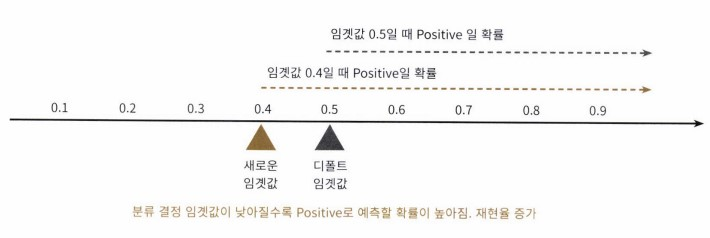

* 임곗값을 낮추면 재현율이 올라가고 정밀도가 낮아진다. 
* Positive 예측값이 많아지면 실제 Positive를 Negative로 예측하는 횟수가 적어져 상대적으로 재현율 값이 높아진다. 

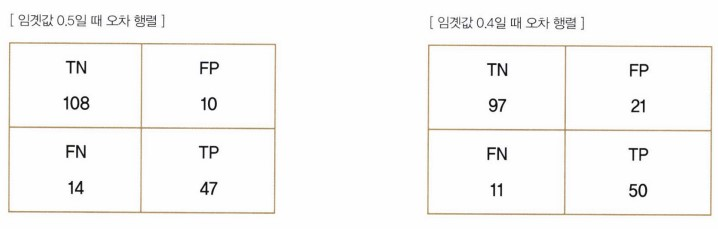

In [21]:
# 임곗값을 0.4~0.6까지 0.05씩 늘리며 평가지표를 조사한다. 
# get_eval_by_threshold()함수를 만든다.

# 테스트를 수행할 모든 임곗값을 리스트로 저장
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds 리스트 객체 내의 값을 차례로 iteration 하면서 Evaluation 실행
    for custom_threshold in thresholds:
        binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict=binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds) 

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도:0.8380, 정밀도:0.7286, 재현율:0.8361
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377


### precision_recall_curve(y_true, probas_pred)
* y_true는 실제 클래스값 배열, probas_pred는 Positive 칼럼의 예측 확률 배열이다.
* 이 함수로 정밀도와 재현율의 값을 배열 형태로 반환 받을 수 있다. 
* 일반적으로 0.11~0.95 정도의 임곗값을 담은 ndarray와 이에 대한 정밀도, 재현율을 담은 ndarray 반환
* 정밀도와 재현율의 임곗값에 따른 변화를 곡선 형태의 그래프로 시각화

In [24]:
# 타이타닉 에측 모델의 임곗값별 정밀도와 재현율
# 레이블이 1일 때 예측 확률 값: predict_proba(X_test)[:,1] -> predict_proba의 반환 배열의 2열이다

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때 예측 확률 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때 예측 확률을 인자로 입력
precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)

# 반환된 임곗값 배열의 열이 147개이므로 10개를 샘플로, 임곗값을 15 단계로 추출
thr_index=np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개', thr_index)
print('샘플용 10개의 임곗값', np.round(thresholds[thr_index], 2))

# 15단계 단위로 추출된 임곗값에 따른 정밀도, 재현율 값
print('샘플 임곗값별 정밀도:',np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율:', np.round(recalls[thr_index], 3)) 

반환된 분류 결정 임곗값 배열의 shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개 [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임곗값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


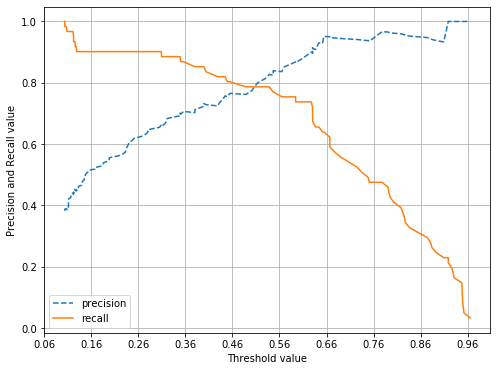

In [25]:
# 정밀도와 재현율의 임곗값에 따른 변화를 곡선 형태의 그래프로 표현
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값, Y축을 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축의 label,legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1]) 

* 주황색 실선: 재현율 / 파란색 점선: 정밀도
* 임곗값이 낮을수록 많은 수의 Positive 예측으로 인해 재현율 값이 극도로 높아지고, 정밀도 값이 낮아진다.
* Logistic Regression 기반의 타이타닉 생존자 예측 모델은 임곗값이 0.45일 때 정밀도와 재현율이 비슷하다.

### 정밀도와 재현율의 맹점
- Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다. 임곗값의 변경은 둘을 상호보완할 수 있는 수준에서 적용되어야 하며, 단순히 하나의 성능 지표를 높이기 위한 수단으로 사용하지 말아야 한다.
- 어느 하나의 값만 강조하는 상황이 되면 안 된다. 정밀도와 재현율의 수치가 적절하게 조합되어야 한다.
- __정밀도가 100%인 경우__
    - 확실한 기준이 되는 경우만 Positive로 예측하고, 나머지는 모두 Negative로 예측한다.
    - 정밀도=TP/(TP+FP) 
- __재현율이 100%인 경우__
    - 모든 값을 Positive로 예측한다. 
    - 재현율=TP/(TP+FN)

## __03_04 F1 스코어__
---
- F1 스코어는 정밀도와 재현율을 결합한 지표. 두 값이 어느 한 쪽으로 치우치지 않을 때 높은 값을 가진다.
- __F1 = 2 / ((1/recall) + (1/precision))__
- 사이킷런의 f1_score( ) 사용

In [27]:
from sklearn.metrics import f1_score
f1=f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1)) 

F1 스코어:0.7805


In [28]:
# 앞서 작성한 get_clf_eval 함수에 F1 스코어를 계산하는 로직 추가
# get_eval_by_threshold 함수를 통해 임곗값이 0.4~0.6일 때 정확도, 정밀도, 재현율, F1 스코어 계산

def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    # F1 스코어 추가
    f1=f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall,f1)) 
    
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds) 

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도:0.8380, 정밀도:0.7286, 재현율:0.8361, F1:0.7786
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033, F1:0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869, F1:0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541, F1:0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377, F1:0.8036


## __03_05 ROC 곡선과 AUC__
---
- __ROC__ 곡선은 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표이다.
- FPR이 변할 때 TPR(재현율)이 어떻게 변하는지를 나타내는 곡선이다. FPR을 X축으로, TPR을 Y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.
---
- TPR(민감도)는 실제값 Positive가 정확히 예측돼야 하는 수준을 나타낸다. 
- TNR(특이성)은 실제값 Negative가 정확히 예측돼야 하는 수준을 나타낸다. 
- TNR은 TPR에 대응하는 지표이다. 
- __FPR__ = FP/(FP+TN) = 1-TNR = 1-특이성


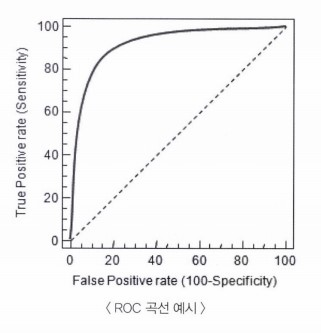

* 가운데 직선은 ROC 곡선의 최저 값, ROC 곡선은 가운데 직선과 멀수록 성능이 뛰어나다.
- ROC 곡선은 FPR을 0부터 1까지 변경하며 TPR의 변화 값을 구한다. FPR을 0부터 1까지 변경하기 위해 앞의 분류 결정 임곗값을 사용한다. 

### roc_curve( )
- precision_recall_curve()와 사용법이 유사하지만 반환값이 FPR, TPR, 임곗값으로 구성되어 있다.
- 입력 파라미터는 실제 클래스 값 array인 __y_true__, predict_prob()의 반환값 array에서 Positive 열의 예측 확률인 __y_score__ 가 있다 

In [30]:
# 타이타닉 생존자 예측 모델의 FPR, TPR, 임곗값
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때 예측 확률
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds=roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열의 행이 47건이므로 샘플 10개 추출, 임곗값을 5단계로 추출한다.
thr_index=np.arange(0, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

# 5단계 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))


샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개의 임곗값: [1.97 0.75 0.63 0.59 0.49 0.4  0.31 0.15 0.12 0.11 0.1 ]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.059 0.127 0.161 0.237 0.483 0.61  0.703 0.814]
샘플 임곗값별 TPR: [0.    0.475 0.672 0.754 0.787 0.852 0.885 0.902 0.934 0.967 0.984]


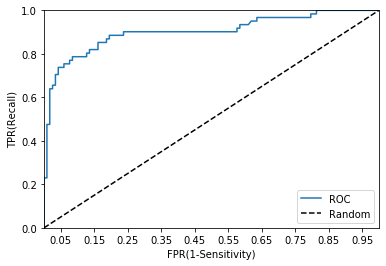

In [31]:
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 반환
    fprs, tprs, thresholds=roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 직선을 그림
    plt.plot([0,1],[0,1],'k--',label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y 축 이름 설정
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:,1]) 

- ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하고, 분류 성능 지표로 사용되는 건 ROC 곡선 면적에 기반한 AUC 값이다.
- AUC는 ROC 곡선 밑 면의 면적을 구한 것으로, 1에 가까울수록 좋은 수치이다. 
- AUC의 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다. 

### roc_auc_score( )

In [32]:
from sklearn.metrics import roc_auc_score

pred=lr_clf.predict(X_test)
roc_score=roc_auc_score(y_test, pred)
print('ROC AUC 값:{0:.4f}'.format(roc_score)) 

ROC AUC 값:0.8341


## __03_06 피마 인디언 당뇨병 예측__
---
- 피마 인디언 당뇨병 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 만든다.
- 정확도, 정밀도, 재현율, F1스코어, ROC AUC 평가 지표를 적용


--- 
##### 변수 설명
- __Pregnancies__: 임신 횟수
- __Glucose__: 포도당 부하 검사 수치(mm Hg)
- __SkinThickness__: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
- __Insullin__: 혈청 인슐린(mu U/ml)
- __BMI__: 체질량지수((kg/cm)^2)
- __DiabetesPedigreeFunction__: 당뇨 내력 가중치 값
- __Age__: 나이
- __Outcome__: 클래스 결정 값(0 or 1)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data=pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head() 

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- 전체 768개의 값 중 Negative 500, Positive 268로 Negative가 상대적으로 많은 것을 확인할 수 있음.

In [36]:
# feature type과 Null 개수 확인
diabetes_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- Null값은 없고, 모두 숫자형이다. 별도의 feature 인코딩은 필요하지 않아 보인다.

In [38]:
# 로지스틱 회귀를 이용해 예측 모델 생성
# 피처 데이터 세트와 클래스 데이터 세트로 분리 > 학습 데이터 세트와 테스트 데이터 세트로 분리

# 피처 데이터 세트 X, 레이블 데이터 세트 y 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값이다. 칼럼 위치 -1을 이용해 추출
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred) 

오차행렬
[[88 12]
 [23 31]]
정확도:0.7727, 정밀도:0.7209, 재현율:0.5741, F1:0.6392


C:\Users\82109\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


- 예측 정확도 77.27%, 재현율 59.26% 
- 전체 데이터의 65%가 Negative이기 때문에 정확도보단 재현율 성능에 초점을 맞춘다. 
- 우선 __precision_recall_curve_plot__ 함수를 이용해 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인한다.

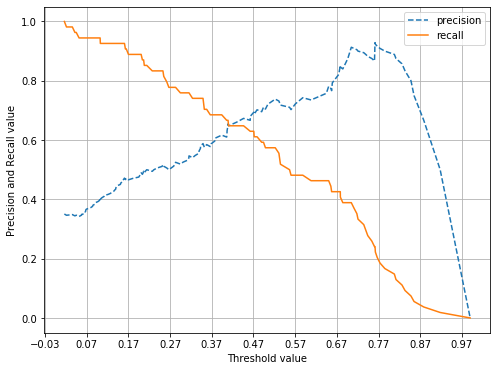

In [39]:
pred_proba_c1=lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1) 

- 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 균형을 맞출 것 같지만, 두 지표 모두 0.7이 안되는 수치
- 임의로 임곗값을 조작하기 전에 데이터 값을 점검하기 위해 __describe()__를 사용해 분포도를 살펴본다.

In [40]:
diabetes_data.describe() 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min 값이 0인 피처가 많다. 포도당 수치인 Glucose의 min이 0인 것은 이상하다! 히스토그램을 확인한다.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

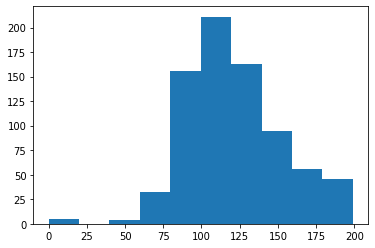

In [41]:
plt.hist(diabetes_data['Glucose'], bins=10) 

- min 값이 0인 피처에 대해 0의 개수와 전체 개수 대비 몇 퍼센트인지 조사한다. 
- Glucose, BloodPressure, SkinThickness, Insullin, BMI에 대해 조사한다.

In [43]:
# 0 값을 조사할 피처 명 리스트
zero_features=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 개수
total_count=diabetes_data['Glucose'].count()

# 피처별로 반복하여 데이터 값이 0인 건수를 추출하고 퍼센트 계산
for feature in zero_features:
    zero_count=diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count)) 

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


- SkinThickness와 Insulin의 0 값은 전체의 29.56%, 48.7%로 상당히 많다.
- 전체 데이터 건수가 많지 않아 이들을 삭제하는 경우엔 학습 수행이 어려우므로 평균값으로 대체한다.

In [44]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
mean_zero_features=diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features) 

In [46]:
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test) 
get_clf_eval(y_test, pred) 

오차행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804


- 재현율이 낮아 개선이 필요하다. 분류 결정 임곗값을 변화시키면서 재현율 값이 얼마나 개선되는지 확인
- 임곗값에 따른 평가 수치 출력은 get_eval_by_threshold() 함수를 이용한다. 

In [47]:
thresholds=[0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds) 

임곗값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도:0.7143, 정밀도:0.5658, 재현율:0.7963, F1:0.6615
임곗값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도:0.7403, 정밀도:0.6000, 재현율:0.7778, F1:0.6774
임곗값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도:0.7468, 정밀도:0.6190, 재현율:0.7222, F1:0.6667
임곗값: 0.39
오차행렬
[[78 22]
 [16 38]]
정확도:0.7532, 정밀도:0.6333, 재현율:0.7037, F1:0.6667
임곗값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도:0.7792, 정밀도:0.6923, 재현율:0.6667, F1:0.6792
임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857
임곗값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931
임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804


- 재현율을 높이기 위해 가장 좋은 임곗값은 0.33 > 정밀도가 0.5972로 낮아져 좋은 선택은 아니다.
- 임곗값이 0.48일 때 정밀도 0.6481, 정밀도 0.7447이므로 ROC AUC는 임곗값 0.48일 때 제일 좋다.
- 앞의 로지스틱 회귀 모델을 임곗값을 0.48로 낮춘 상태에서 다시 예측한다. predict()는 임의로 임곗값을 변환할 수 없기 때문에 Binarizer 클래스의 predict_proba()로 추출한 예측 결과를 반환해서 사용한다.

In [48]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer=Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼을 Binarizer로 변환
pred_th_048=binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048) 

오차행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931


## __03_07 정리__
- 분류에 사용되는 성능평가지표
       - 정확도, 오차행렬, 정밀도, 재현율, F1스코어, ROC AUC
- __오차행렬__: Negative, Positive 값을 가지는 실제 클래스 값과 예측 클래스 값이 True와 False에 따라 TN, FP, FN, TP로 매핑되는 4분면 행렬을 기반으로 예측 성능을 평가. 정확도, 정밀도, 재현율 수치는 TN, FP, FN, TP 값을 다양하게 결합해 만들어지며, 이를 통해 분륳 모델 예측 성능의 오류가 어떠한 모습으로 발생하는 지 알 수 있다. 
- __정밀도, 재현율__: Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가지표. 재현율이 즁요한 경우와 정밀도가 중요한 경우 구분
- __F1 스코어__: 정밀도와 재현율을 결합한 평가 지표. 두 값이 어느 한 쪽으로 치우치지 않을 때 가장 큰 값을 가진다. 
- __ROC-AUC__: 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 평가지표. AUC 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다. 